# Logistic Regression Pipeline for HeLa (GREG)

This notebook assesses variaegated implementations of the logistic regression models for the data dervied from the HeLa cell-line in GREG.

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [2]:
install.packages("glmnet", 
                 repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/", 
                 dependencies = TRUE)
library(glmnet)

also installing the dependency ‘lars’





The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpdEEDsm/downloaded_packages


Loading required package: Matrix

Loaded glmnet 4.0-2



### <a id=link2>2. Loading Data </a>

In [3]:
helagreg <- read.table("HeLaforML.txt", header = TRUE) ## loading data
helagreg<- helagreg[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [4]:
head(helagreg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
2,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
3,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
4,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
5,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.07964071,Non-Hub
6,16.31532,0.3485739,0.7310137,0.5121474,0.2671445,0.9937343,0.8823614,1.233227,0.03706458,0.08740367,0,1.506197,13.00798194,Non-Hub


<p align = "justify"><i> cv.glmnet </i> is a function that performs cross-validation and engenders different values of lambda (mean cross-validation error). The default value for a CV-run is 10, meaning thereby that the data is partitioned in 10 near-equal subsets. At every iteration, the model is trained with the 9 folds and the remaining fold is used for testing. A lambda value represents the prediction error for every train-test case. The number of folds are tuneable (<i>nfolds</i> parameter).</p> 

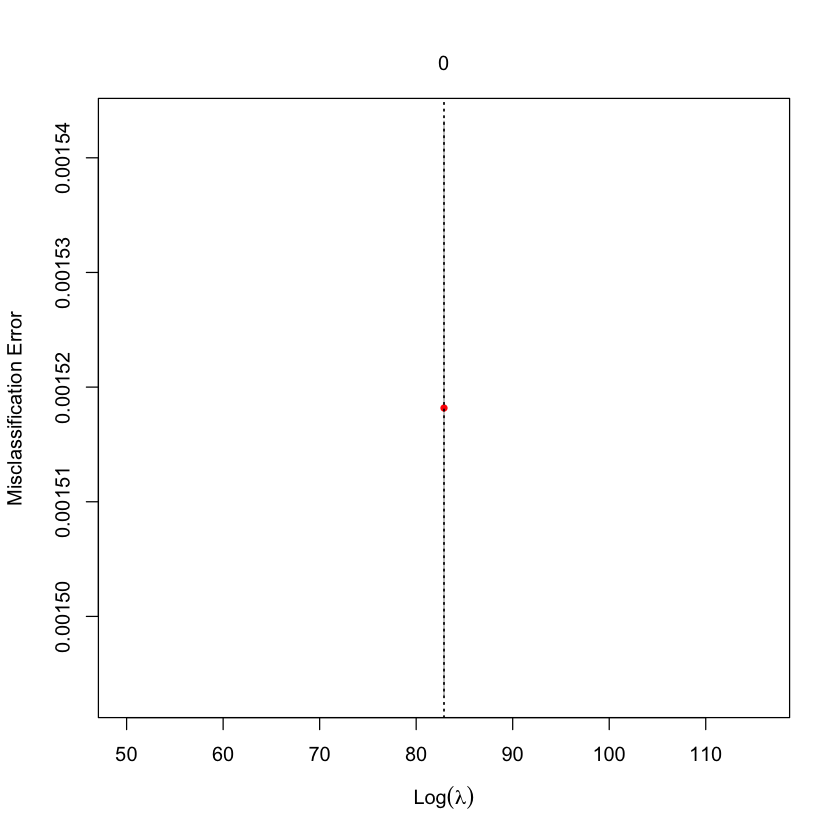

In [14]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(helagreg[,1:13]),
                         helagreg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 20,
                         nfolds = 20)


plot(cv.modelfit)

In [21]:
coef(cv.modelfit)

14 x 1 sparse Matrix of class "dgCMatrix"
                   1
(Intercept) 6.488725
CTCF        0.000000
EP300       .       
H3K27me3    .       
H3K36me3    .       
H3K4me1     .       
H3K4me2     .       
H3K4me3     .       
H3K9ac      .       
H3K9me3     .       
RAD21       .       
RNA.Seq     .       
RNAPol2     .       
RNAPol3     .       

In [15]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 1 lambda values in all:
 9.9e+35 
, out of which 9.9e+35 is the minimum, while 9.9e+35 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [16]:
set.seed(2)
modelfit <- glmnet(as.matrix(helagreg[,1:13]),
                   helagreg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = min(cv.modelfit$lambda))
# Listing non-zero coefficients
print(modelfit$beta[,1])

    CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
       0        0        0        0        0        0        0        0 
 H3K9me3    RAD21  RNA.Seq  RNAPol2  RNAPol3 
       0        0        0        0        0 


For a standard usage, supplying a single <i>lambda</i> value is not advisable (See <a href= "https://cran.r-project.org/web/packages/glmnet/glmnet.pdf" > here </a>). There could be a convergence issue, as above, and so the better ways is to have the function decide for itself amongst an array of values. Let us attempt again, with the new theme.

In [17]:
set.seed(3)
modelfit <- glmnet(as.matrix(helagreg[,1:13]),
                   helagreg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = cv.modelfit$lambda)
# Listing non-zero coefficients
print(modelfit$beta[,1])

    CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
       0        0        0        0        0        0        0        0 
 H3K9me3    RAD21  RNA.Seq  RNAPol2  RNAPol3 
       0        0        0        0        0 


In [22]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)        CTCF       EP300    H3K27me3    H3K36me3     H3K4me1 
   6.488725    0.000000    0.000000    0.000000    0.000000    0.000000 
    H3K4me2     H3K4me3      H3K9ac     H3K9me3       RAD21     RNA.Seq 
   0.000000    0.000000    0.000000    0.000000    0.000000    0.000000 
    RNAPol2     RNAPol3 
   0.000000    0.000000

14 x 1 sparse Matrix of class "dgCMatrix"
                  s0
(Intercept) 6.488725
CTCF        0.000000
EP300       .       
H3K27me3    .       
H3K36me3    .       
H3K4me1     .       
H3K4me2     .       
H3K4me3     .       
H3K9ac      .       
H3K9me3     .       
RAD21       .       
RNA.Seq     .       
RNAPol2     .       
RNAPol3     .       

In [23]:
set.seed(4) # for reproducibility of results.
helagreg$Class <- as.numeric(as.factor(helagreg$Class))-1
part <- sample(2, nrow(helagreg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- helagreg[part==1,]
test <- helagreg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

helamodel <- glm(formula = Class ~ .,
               data = train,
               family = "binomial")
summary(helamodel)

So, now we have 1063189 training rows and 455737 testing rows


Call:
glm(formula = Class ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9027   0.0519   0.0549   0.0564   2.0933  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.4777203  0.0352932 183.540  < 2e-16 ***
CTCF         0.0429154  0.0163365   2.627  0.00861 ** 
EP300        0.0064907  0.0036908   1.759  0.07865 .  
H3K27me3     0.2322200  0.0314926   7.374 1.66e-13 ***
H3K36me3    -0.1337062  0.0225953  -5.917 3.27e-09 ***
H3K4me1     -0.1120906  0.0119630  -9.370  < 2e-16 ***
H3K4me2      0.0193594  0.0138221   1.401  0.16133    
H3K4me3     -0.0223866  0.0151659  -1.476  0.13991    
H3K9ac      -0.0069828  0.0119912  -0.582  0.56035    
H3K9me3      0.0684054  0.0447245   1.529  0.12614    
RAD21       -0.0361151  0.0088728  -4.070 4.69e-05 ***
RNA.Seq     -0.0002798  0.0004578  -0.611  0.54107    
RNAPol2     -0.0022652  0.0033201  -0.682  0.49508    
RNAPol3      0.0001446  0.0046036 

<h5> Variance Inflation Factors(VIF) </h5>


<p align= "justify"> The state of <a href = "https://www.investopedia.com/terms/m/multicollinearity.asp" > multicollinearity </a> is a common check enroute building of an effective regression model. When two or more predictor(independent) variables are correlated with each other, they do not offer much to the model structure and kind of induce <i>redundancy</i>.</p>
<p align="justify"> A general guideline is that a VIF larger than 5, then that predictor is more related to the other predictors than it is to the response. Contrarily, a VIF value of 1 for a predictor variable indicates that there is no correlation with other predictors, and a VIF value between 1 and 5 is representative of a moderate correlation. <b>The user can choose to remove the independent variables with a high VIF and a high p-value</b>.</p>

In [24]:
install.packages("rms",
                 repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/", 
                 dependencies = TRUE)
library(rms)

vif(helamodel)

also installing the dependencies ‘inline’, ‘V8’, ‘RcppParallel’, ‘rstan’, ‘rstantools’, ‘loo’, ‘StanHeaders’, ‘mice’, ‘rmsb’





  There is a binary version available but the source version is later:
      binary source needs_compilation
rstan 2.21.1 2.21.2              TRUE

Error in download.file(url, destfile, method, mode = "wb", ...) : 
  download from 'https://cran.us.r-project.org/bin/macosx/contrib/4.0/rmsb_0.0.1.tgz' failed

The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpdEEDsm/downloaded_packages


installing the source package ‘rstan’




Error in download.file(url, destfile, method, mode = "wb", ...) : 
  download from 'https://cran.us.r-project.org/src/contrib/rstan_2.21.2.tar.gz' failed


Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 5.989462  2.306153 15.119464 14.679885  3.140537  6.871682 10.931912  8.601231 
  H3K9me3     RAD21   RNA.Seq   RNAPol2   RNAPol3 
 1.814682  3.103366  1.021214  1.799090  1.646538

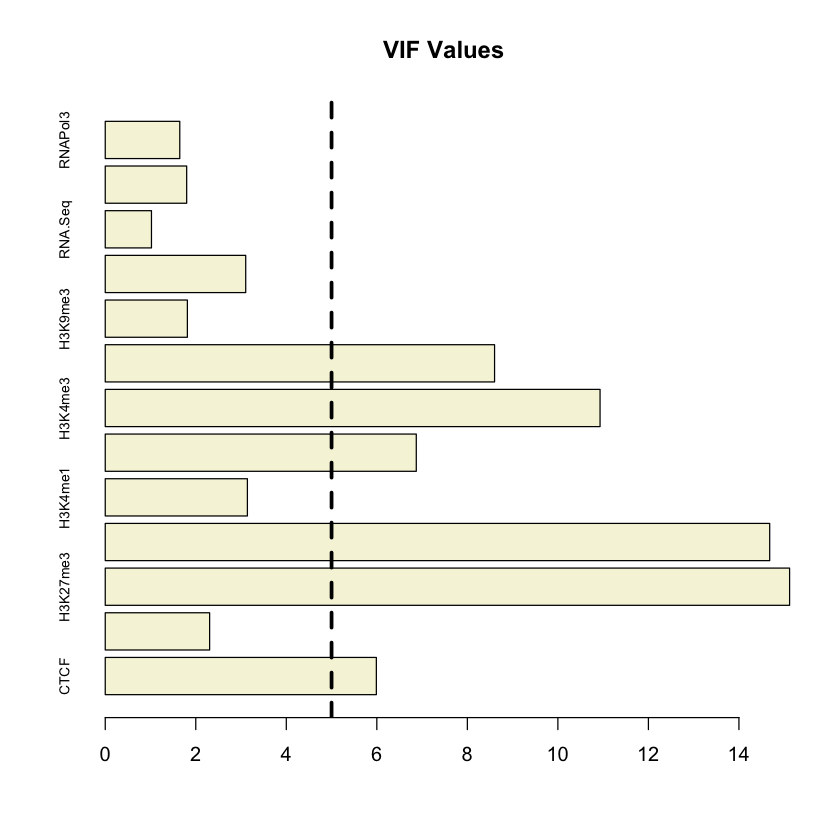

In [26]:
#create horizontal bar chart to display each VIF value
barplot(vif(helamodel), main = "VIF Values", horiz = TRUE, col = "beige", cex.names=.7)

#add vertical line at 5
abline(v = 5, lwd = 3, lty = 2)

Initial observation is that amongst others, the variable <b>H3K4me2</b>, <b>H3K4me3</b>, and <b>H3K9ac</b> have a high p-value and relatively high VIF. In such a case, these can be omitted from the model. Let us re-design the model without YY1.  

In [27]:
helamodel1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = train,
               family = "binomial")
summary(helamodel1)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9130   0.0520   0.0552   0.0565   1.6372  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.4734885  0.0351001 184.429  < 2e-16 ***
CTCF         0.0224393  0.0132442   1.694 0.090214 .  
EP300        0.0059352  0.0036119   1.643 0.100330    
H3K27me3     0.2426261  0.0306350   7.920 2.38e-15 ***
H3K36me3    -0.1251277  0.0219410  -5.703 1.18e-08 ***
H3K4me1     -0.1162102  0.0105832 -10.981  < 2e-16 ***
H3K9me3      0.0671202  0.0445909   1.505 0.132261    
RAD21       -0.0316146  0.0084528  -3.740 0.000184 ***
RNA.Seq     -0.0003837  0.0004256  -0.901 0.367347    
RNAPol2     -0.0048134  0.0015522  -3.101 0.001928 ** 
RNAPol3     -0.0005671  0.0042925  -0.132 0.894898    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

In [28]:
# Examine the VIF for the variables in the new model.
vif(helamodel1)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K9me3     RAD21   RNA.Seq 
 4.286340  2.267072 15.147141 14.619347  2.636639  1.835996  2.887498  1.007810 
  RNAPol2   RNAPol3 
 1.024716  1.593891

This seems a good improvisation than before as just two variables (<i>H3K27me3</i> and <i>H3K36me3</i>) demonstrate a high p-value, but an acceptable VIF. We'll stick to this model.

In [29]:
yTrain <- predict(helamodel1, train, type = "response")
head(yTrain)

1         2         3         4         6        10 
0.9984585 0.9984585 0.9984585 0.9984585 0.9990022 0.9982617

In [30]:
head(train)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.00000,0.000000,0.0000000,1
2,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.00000,0.000000,0.0000000,1
3,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.00000,0.000000,0.0000000,1
4,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0.00000,0.000000,0.0000000,1
6,16.315324,0.3485739,0.7310137,0.5121474,0.2671445,0.9937343,0.8823614,1.233227,0.03706458,0.08740367,0.00000,1.506197,13.0079819,1
10,1.112408,0.0000000,1.0082948,2.5363492,0.5046062,0.8233798,1.1974905,1.574332,0.00000000,0.00000000,12.20714,1.862927,0.5574849,1


In [31]:
prediction_probabilities_train <- ifelse(yTrain > 0.5, 1, 0) # Probabilities to Labels conversion
confusion_matrix_train <- table(Predicted = prediction_probabilities_train, Actual = train$Class)
print(confusion_matrix_train)

         Actual
Predicted       0       1
        0       0       2
        1    1646 1061541


In [32]:
misclassfication_error_train <- 1- sum(diag(confusion_matrix_train))/sum(confusion_matrix_train)
cat("The misclassification error in train data is",
    (round(misclassfication_error_train*100)), "percent")

The misclassification error in train data is 0 percent

In [33]:
yTest <- predict(helamodel1, test, type = "response")
prediction_probabilities_test <- ifelse(yTest > 0.5, 1, 0)
confusion_matrix_test <- table(Predicted = prediction_probabilities_test, Actual = test$Class)
print(confusion_matrix_test)

         Actual
Predicted      0      1
        0      0      4
        1    660 455073


In [34]:
misclassfication_error_test <- 1- sum(diag(confusion_matrix_test))/sum(confusion_matrix_test)
cat("The misclassification error in test data is",
    (round(misclassfication_error_test*100)), "percent")

The misclassification error in test data is 0 percent

In [35]:
overall_p <- with(helamodel1,
                  pchisq(null.deviance-deviance,
                         df.null-df.residual,
                         lower.tail = FALSE))
cat("The statistical significance for the model is", overall_p, "\n")

The statistical significance for the model is 2.846218e-37 


In [36]:
cat("The confidence level for this model is",
    ((1-overall_p)*100), "percent")

The confidence level for this model is 100 percent

We tried to omit some variables on the basis of their significance, but we can clearly observe that the model has **zero sensitivity** and **high specificity** due to the class-imbalance problem in data. It means that the model is **highly biased towards the Non-Hubs** and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (0: hubs).

In [37]:
library(caret)
library(e1071)


Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster



Attaching package: ‘e1071’


The following object is masked from ‘package:Hmisc’:

    impute




In [38]:
sensitivity(confusion_matrix_train)

[1] 0

In [39]:
specificity(confusion_matrix_train)

[1] 0.9999981

In [40]:
sensitivity(confusion_matrix_test)

[1] 0

In [41]:
specificity(confusion_matrix_test)

[1] 0.9999912

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [42]:
table(helagreg$Class)


      0       1 
   2306 1516620 

We can articulate that the hubs(class marked with '0') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3).

In [43]:
install.packages("ROSE", 
                 dependencies = TRUE, 
                 repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
library(ROSE)


The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpdEEDsm/downloaded_packages


Loaded ROSE 0.0-3




In [45]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1518926)$data

In [46]:
table(overTrain$Class)


      0       1 
 457383 1061543 

Still better. Let's run the model again to see if there is any improvement in the performance.

In [47]:
helamodel1Over <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = overTrain,
               family = "binomial")
summary(helamodel1Over)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0683  -1.4121   0.7889   0.8227   8.4904  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.9778379  0.0029372 332.913   <2e-16 ***
CTCF        -0.0353470  0.0020226 -17.476   <2e-16 ***
EP300       -0.1209846  0.0027613 -43.814   <2e-16 ***
H3K27me3     0.2306379  0.0024355  94.697   <2e-16 ***
H3K36me3    -0.0889530  0.0019789 -44.951   <2e-16 ***
H3K4me1     -0.1458905  0.0017340 -84.134   <2e-16 ***
H3K9me3      0.0915528  0.0034969  26.181   <2e-16 ***
RAD21       -0.0137548  0.0010995 -12.511   <2e-16 ***
RNA.Seq     -0.0080971  0.0002492 -32.497   <2e-16 ***
RNAPol2     -0.0124905  0.0004097 -30.490   <2e-16 ***
RNAPol3     -0.0011223  0.0005347  -2.099   0.0358 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 

In [48]:
yTestOver <- predict(helamodel1Over, test, type = "response")
prediction_probabilities_testOver <- ifelse(yTestOver > 0.5, 1, 0)
confusion_matrix_testOver <- table(Predicted = prediction_probabilities_testOver, Actual = test$Class)
print(confusion_matrix_testOver)

         Actual
Predicted      0      1
        0     42  10738
        1    618 444339


In [49]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testOver))*100, "%")

The sensitivity of the model is 6.363636 %

In [50]:
cat("The specificity of the model is", (specificity(confusion_matrix_testOver))*100, "%")

The specificity of the model is 97.6404 %

This is better than before but still not good enough. Maybe we can try the other approach.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [62]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N = 3500)$data
table(underTrain$Class)


   0    1 
1646 1854 

In [63]:
helamodel1Under <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = underTrain,
               family = "binomial")
summary(helamodel1Under)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = underTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7648  -1.1909   0.9082   1.0519   6.8411  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.568479   0.077887   7.299 2.90e-13 ***
CTCF        -0.051512   0.048970  -1.052 0.292844    
EP300       -0.430186   0.095157  -4.521 6.16e-06 ***
H3K27me3     0.210505   0.058380   3.606 0.000311 ***
H3K36me3    -0.039574   0.043032  -0.920 0.357760    
H3K4me1     -0.085154   0.041251  -2.064 0.038989 *  
H3K9me3      0.214983   0.082817   2.596 0.009435 ** 
RAD21       -0.010545   0.027243  -0.387 0.698706    
RNA.Seq     -0.013737   0.005331  -2.577 0.009976 ** 
RNAPol2     -0.002997   0.007981  -0.376 0.707230    
RNAPol3     -0.347266   0.104097  -3.336 0.000850 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.

In [64]:
yTestUnder <- predict(helamodel1Under, test, type = "response")
prediction_probabilities_testUnder <- ifelse(yTestUnder > 0.5, 1, 0)
confusion_matrix_testUnder <- table(Predicted = prediction_probabilities_testUnder, Actual = test$Class)
print(confusion_matrix_testUnder)

         Actual
Predicted      0      1
        0    287  85897
        1    373 369180


In [65]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testUnder))*100, "%")

The sensitivity of the model is 43.48485 %

In [66]:
cat("The specificity of the model is", (specificity(confusion_matrix_testUnder))*100, "%")

The specificity of the model is 81.12473 %

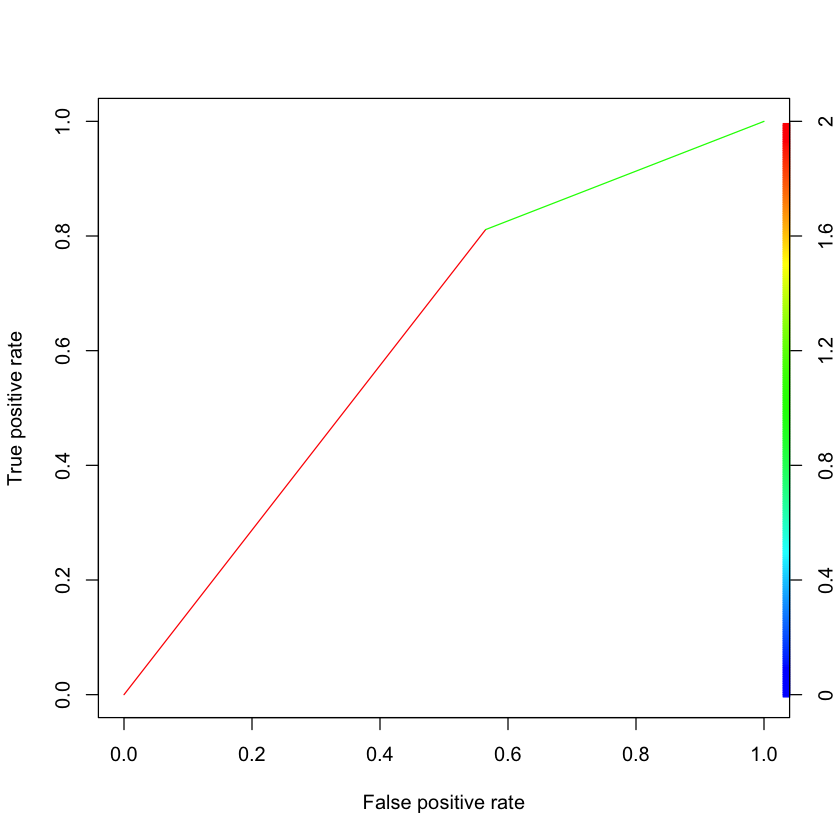

In [67]:
library(ROCR)

pred <- prediction(prediction_probabilities_testUnder, test$Class)
perf <- performance(pred, "tpr", "fpr")
plot(perf, colorize = TRUE)

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [68]:
install.packages("DMwR", 
                 dependencies = TRUE, 
                 repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/")
library(DMwR)


The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpdEEDsm/downloaded_packages


Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [69]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.
train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 100000, k = 5, perc.under = 100)

table(smoteData$Class)


      0       1 
1647646 1646000 

In [70]:
helamodel1SMOTE <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = smoteData,
               family = "binomial")
summary(helamodel1SMOTE)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = smoteData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6229  -1.1658  -0.0303   1.0968   8.4904  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  0.2729651  0.0023355  116.876  < 2e-16 ***
CTCF        -0.0381486  0.0015507  -24.601  < 2e-16 ***
EP300       -0.3419353  0.0030330 -112.740  < 2e-16 ***
H3K27me3     0.1807136  0.0018829   95.977  < 2e-16 ***
H3K36me3    -0.0902414  0.0014233  -63.401  < 2e-16 ***
H3K4me1     -0.1088843  0.0013977  -77.901  < 2e-16 ***
H3K9me3      0.1695179  0.0026949   62.903  < 2e-16 ***
RAD21       -0.0042598  0.0008344   -5.105 3.31e-07 ***
RNA.Seq     -0.0101044  0.0001843  -54.817  < 2e-16 ***
RNAPol2     -0.0124459  0.0003317  -37.524  < 2e-16 ***
RNAPol3     -0.0464298  0.0025978  -17.873  < 2e-16 ***
---
Signif. codes:  0 ‘***’

Let us now examine this model with the test data.

In [71]:
yTestSMOTE <- predict(helamodel1SMOTE, test, type = "response")
prediction_probabilities_testSMOTE <- ifelse(yTestSMOTE > 0.5, 1, 0)
confusion_matrix_testSMOTE <- table(Predicted = prediction_probabilities_testSMOTE, Actual = test$Class)
print(confusion_matrix_testSMOTE)

         Actual
Predicted      0      1
        0    358 117759
        1    302 337318


In [72]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testSMOTE))*100, "%")

The sensitivity of the model is 54.24242 %

In [73]:
cat("The specificity of the model is", (specificity(confusion_matrix_testSMOTE))*100, "%")

The specificity of the model is 74.12328 %

This case is somewhat balanced, not only in terms of respective data points but also sensivitiy and specificity of the classifier.

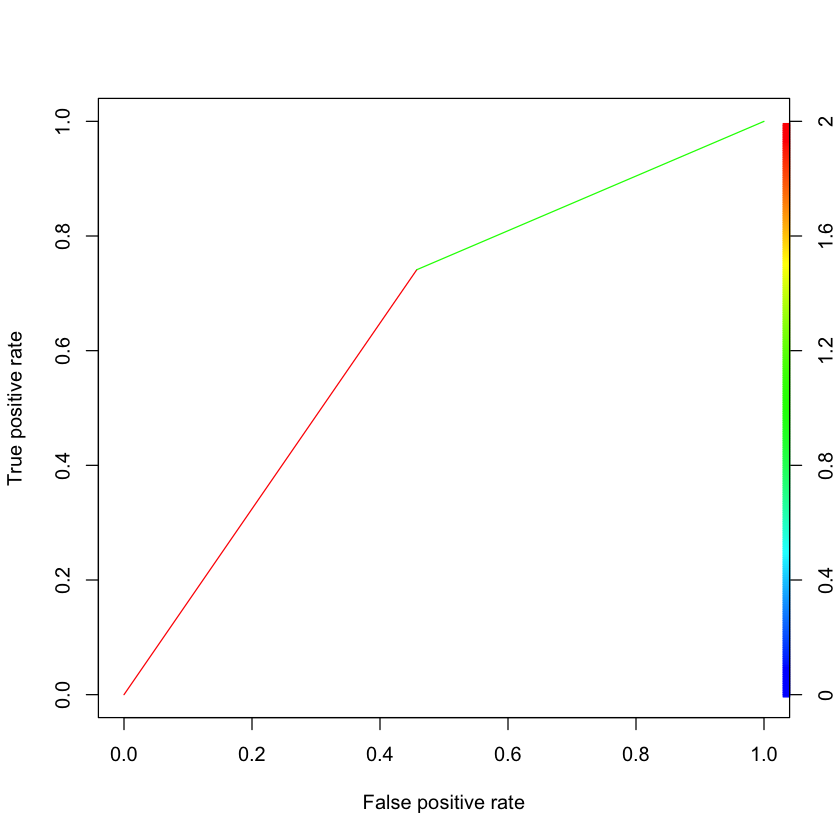

In [74]:
predSMOTE <- prediction(prediction_probabilities_testSMOTE, test$Class)
perfSMOTE <- performance(predSMOTE, "tpr", "fpr")
plot(perfSMOTE, colorize = TRUE)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly better specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [83]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1516620)$data
table(bothTrain$Class)


     1      0 
758890 757730 

In [84]:
helamodel1Both <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3,
               data = bothTrain,
               family = "binomial")
summary(helamodel1Both)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, family = "binomial", 
    data = bothTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0960  -0.7759   1.1736   1.6019  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.2401971  0.0031250 -76.862  < 2e-16 ***
CTCF         0.0507811  0.0021788  23.307  < 2e-16 ***
EP300        0.2356728  0.0039003  60.424  < 2e-16 ***
H3K27me3    -0.1720608  0.0027330 -62.956  < 2e-16 ***
H3K36me3     0.0937467  0.0020393  45.970  < 2e-16 ***
H3K4me1      0.1588944  0.0020112  79.006  < 2e-16 ***
H3K9me3     -0.1574649  0.0038991 -40.385  < 2e-16 ***
RAD21        0.0052092  0.0011571   4.502 6.73e-06 ***
RNA.Seq      0.0120606  0.0002719  44.365  < 2e-16 ***
RNAPol2      0.0119640  0.0004594  26.043  < 2e-16 ***
RNAPol3      0.0036789  0.0010659   3.451 0.000557 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 

In [85]:
yTestBoth <- predict(helamodel1Both, test, type = "response")
prediction_probabilities_testBoth <- ifelse(yTestBoth > 0.5, 1, 0)
confusion_matrix_testBoth <- table(Predicted = prediction_probabilities_testBoth, Actual = test$Class)
print(confusion_matrix_testBoth)

         Actual
Predicted      0      1
        0    314 349494
        1    346 105583


In [86]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testBoth))*100, "%")

The sensitivity of the model is 47.57576 %

In [87]:
cat("The specificity of the model is", (specificity(confusion_matrix_testBoth))*100, "%")

The specificity of the model is 23.20113 %

These numbers aren't as good. Hitherto, the model with SMOTE data has performed the best.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [88]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(helagreg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- helagreg[parts==1,]
testing <- helagreg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1215249 training rows and 303677 testing rows

With a new data partitioning, let's retrain the model with all variables. We'll check for multicollinear variables later.

In [89]:
helaparetoModel <- glm(formula = Class ~ ., 
                        data = training, 
                        family = "binomial")
summary(helaparetoModel)


Call:
glm(formula = Class ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8861   0.0524   0.0545   0.0560   3.5820  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.501e+00  3.422e-02 189.983  < 2e-16 ***
CTCF         3.566e-02  1.607e-02   2.219   0.0265 *  
EP300        5.954e-03  3.246e-03   1.834   0.0666 .  
H3K27me3     2.251e-01  3.565e-02   6.314 2.72e-10 ***
H3K36me3    -9.776e-02  1.680e-02  -5.818 5.95e-09 ***
H3K4me1     -9.770e-02  1.158e-02  -8.434  < 2e-16 ***
H3K4me2     -8.676e-04  1.236e-02  -0.070   0.9440    
H3K4me3     -2.778e-02  1.354e-02  -2.051   0.0402 *  
H3K9ac      -3.385e-03  1.148e-02  -0.295   0.7682    
H3K9me3      1.888e-02  4.028e-02   0.469   0.6393    
RAD21       -3.562e-02  8.367e-03  -4.257 2.07e-05 ***
RNA.Seq     -2.349e-04  5.606e-04  -0.419   0.6753    
RNAPol2      6.232e-04  4.902e-03   0.127   0.8988    
RNAPol3     -2.329e-05  4.026e-

In [90]:
vif(helaparetoModel)

CTCF    EP300 H3K27me3 H3K36me3  H3K4me1  H3K4me2  H3K4me3   H3K9ac 
2.240349 2.440988 6.723895 6.747002 1.740087 3.130837 8.339049 8.503705 
 H3K9me3    RAD21  RNA.Seq  RNAPol2  RNAPol3 
1.199591 3.214624 1.016901 2.958195 1.098568

From the inference above, we could omit the variable <b>H3K9ac</b> as it has a high VIF and also a high p-value.

In [91]:
helaparetoModel1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, 
                        data = training, 
                        family = "binomial")
summary(helaparetoModel1)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + 
    RNAPol3, family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8859   0.0524   0.0545   0.0560   3.5923  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  6.501e+00  3.423e-02 189.906  < 2e-16 ***
CTCF         3.631e-02  1.594e-02   2.278 0.022731 *  
EP300        5.919e-03  3.241e-03   1.826 0.067828 .  
H3K27me3     2.248e-01  3.568e-02   6.301 2.97e-10 ***
H3K36me3    -9.753e-02  1.679e-02  -5.810 6.24e-09 ***
H3K4me1     -9.793e-02  1.156e-02  -8.472  < 2e-16 ***
H3K4me2     -6.205e-04  1.232e-02  -0.050 0.959818    
H3K4me3     -3.075e-02  8.967e-03  -3.429 0.000606 ***
H3K9me3      1.876e-02  4.028e-02   0.466 0.641397    
RAD21       -3.579e-02  8.342e-03  -4.290 1.78e-05 ***
RNA.Seq     -2.376e-04  5.605e-04  -0.424 0.671664    
RNAPol2     -8.106e-

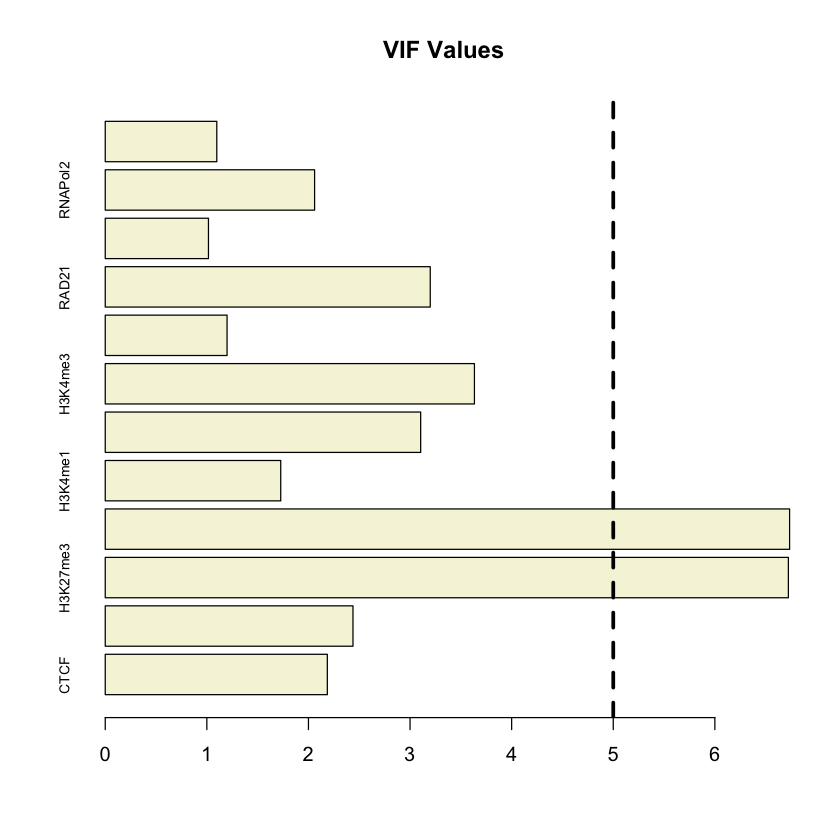

In [93]:
#create horizontal bar chart to display each VIF value
barplot(vif(helaparetoModel1), main = "VIF Values", horiz = TRUE, col = "beige", cex.names=.7)

#add vertical line at 5
abline(v = 5, lwd = 3, lty = 2)

In [94]:
yTesting <- predict(helaparetoModel1, testing, type = "response")
prediction_probabilities_testing <- ifelse(yTesting > 0.5, 1, 0)
confusion_matrix_testing <- table(Predicted = prediction_probabilities_testing, Actual = testing$Class)
print(confusion_matrix_testing)

         Actual
Predicted      0      1
        0      0      1
        1    435 303241


We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "1"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [95]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, 
                    training, 
                    perc.over = 10000, 
                    k = 7, 
                    perc.under = 99)
table(smoteDatum$Class)


     0      1 
188971 185229 

In [96]:
helaparetoModel1Smote <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3, 
                             data = smoteDatum, 
                             family = "binomial")
summary(helaparetoModel1Smote)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K4me3 + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + 
    RNAPol3, family = "binomial", data = smoteDatum)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8248  -1.1591  -0.2532   1.0917   8.4904  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.3513622  0.0066118  53.142  < 2e-16 ***
CTCF        -0.0210017  0.0043624  -4.814 1.48e-06 ***
EP300       -0.4282157  0.0086901 -49.277  < 2e-16 ***
H3K27me3     0.1371874  0.0046598  29.441  < 2e-16 ***
H3K36me3    -0.1473137  0.0039885 -36.935  < 2e-16 ***
H3K4me1     -0.1391937  0.0044433 -31.327  < 2e-16 ***
H3K4me2      0.2091619  0.0047396  44.131  < 2e-16 ***
H3K4me3     -0.1730627  0.0040596 -42.631  < 2e-16 ***
H3K9me3      0.1368641  0.0069547  19.679  < 2e-16 ***
RAD21       -0.0118221  0.0024280  -4.869 1.12e-06 ***
RNA.Seq     -0.0027791  0.0004909  -5.661 1.50e-08 ***
RNAPol2      0.009

In [97]:
yTestingSmote <- predict(helaparetoModel1Smote, testing, type = "response")
prediction_probabilities_testingSmote <- ifelse(yTestingSmote > 0.5, 1, 0)
confusion_matrix_testingSmote <- table(Predicted = prediction_probabilities_testingSmote, Actual = testing$Class)
print(confusion_matrix_testingSmote)

         Actual
Predicted      0      1
        0    237  83746
        1    198 219496


In [98]:
cat("The sensitivity of the model is", (sensitivity(confusion_matrix_testingSmote))*100, "%")

The sensitivity of the model is 54.48276 %

In [99]:
cat("The specificity of the model is", (specificity(confusion_matrix_testingSmote))*100, "%")

The specificity of the model is 72.38311 %

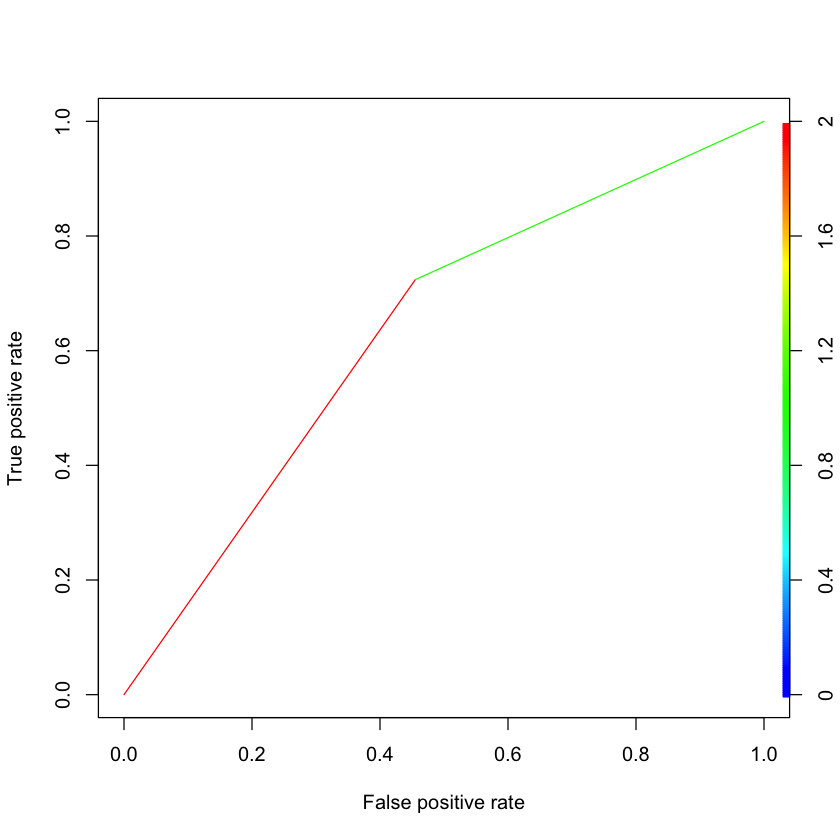

In [100]:
predictingSMOTE <- prediction(prediction_probabilities_testingSmote, testing$Class)
performanceSMOTE <- performance(predictingSMOTE, "tpr", "fpr")
plot(performanceSMOTE, colorize = TRUE)

### <a id=link12>6. Visualizing Predictions </a>

We choose to go with the current model and will save the prediction results, that shall be later utilized for plotting.

In [103]:
helaModel1Predictions <- predict(helaparetoModel1Smote, helagreg, type = "response")
helaModel1PredictionsProbs <- ifelse(helaModel1Predictions > 0.5, 1, 0)

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the H1ESC cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

The workflow commences with the installation of <a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz </a> - the package we aim to deploy for the visualization.

In [104]:
BiocManager::install("Gviz")
library(Gviz)

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'Gviz'




The downloaded binary packages are in
	/var/folders/hm/c3_fjypn62v5xh5b5ygv267m0000gn/T//RtmpdEEDsm/downloaded_packages


Old packages: 'TTR', 'bit64', 'conquer', 'glue', 'mgcv', 'mnormt', 'tidyr',
  'vctrs', 'zip'

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.

Next, we recall the data from the HeLa cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need!

In [109]:
helagregStandard <- read.table("HeLaforML.txt", header = TRUE) ## full data
helagregStandardRegionsClass <- helagregStandard[, c(1:3,17)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [110]:
# Extracting chr21 data

helagregChr21NonHub <- helagregStandardRegionsClass[helagregStandardRegionsClass$chr=="chr21" & helagregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
helagregChr21Hub <- helagregStandardRegionsClass[helagregStandardRegionsClass$chr=="chr21" & helagregStandardRegionsClass$Class=="Hub", ]

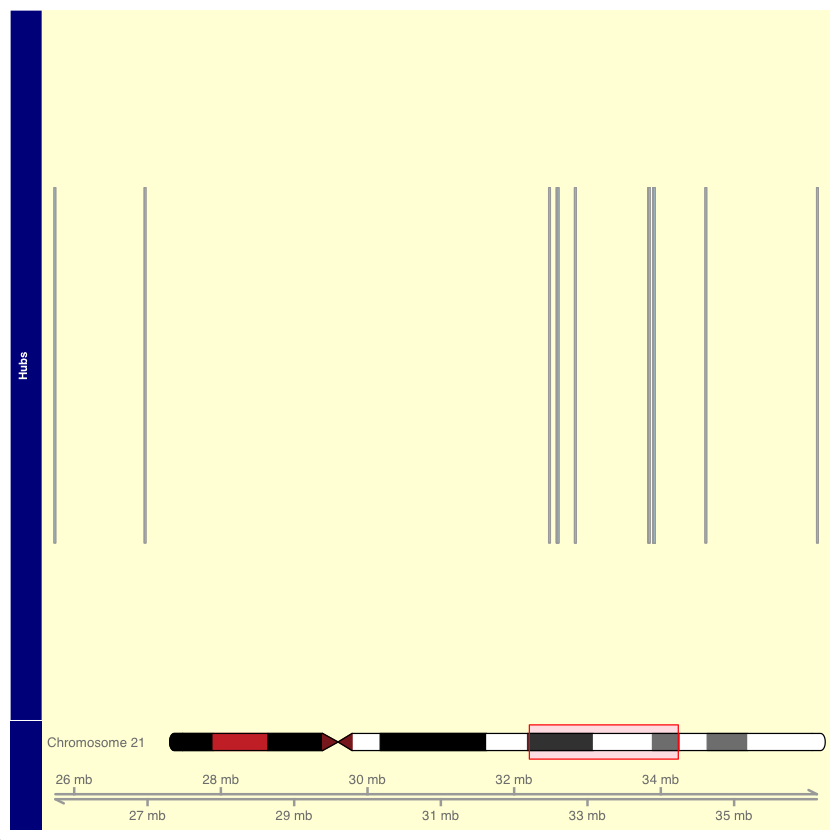

In [111]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = helagregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

In [112]:
print(helagregChr21Hub)

         chr    start      end Class
810027 chr21 25734001 25736000   Hub
810028 chr21 25736001 25738000   Hub
810642 chr21 26964001 26966000   Hub
810643 chr21 26966001 26968000   Hub
813400 chr21 32480001 32482000   Hub
813401 chr21 32482001 32484000   Hub
813452 chr21 32584001 32586000   Hub
813453 chr21 32586001 32588000   Hub
813454 chr21 32588001 32590000   Hub
813455 chr21 32590001 32592000   Hub
813456 chr21 32592001 32594000   Hub
813457 chr21 32594001 32596000   Hub
813458 chr21 32596001 32598000   Hub
813459 chr21 32598001 32600000   Hub
813576 chr21 32832001 32834000   Hub
813577 chr21 32834001 32836000   Hub
813578 chr21 32836001 32838000   Hub
814077 chr21 33834001 33836000   Hub
814078 chr21 33836001 33838000   Hub
814079 chr21 33838001 33840000   Hub
814080 chr21 33840001 33842000   Hub
814081 chr21 33842001 33844000   Hub
814111 chr21 33902001 33904000   Hub
814112 chr21 33902001 33904000   Hub
814113 chr21 33904001 33906000   Hub
814114 chr21 33904001 33906000   Hub
8

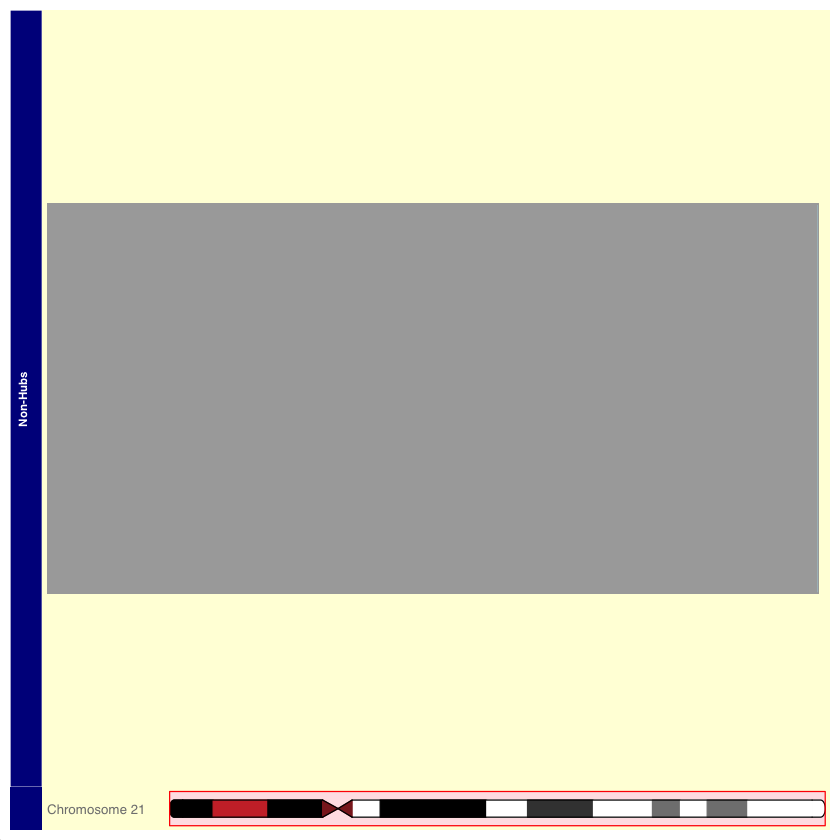

In [113]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = helagregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [114]:
helagregPredicted <- cbind(helagregStandardRegionsClass, helaModel1PredictionsProbs)
names(helagregPredicted)[names(helagregPredicted)=="helaModel1PredictionsProbs"] <- "Prediction"
helagregPredicted$Prediction <- ifelse(helagregPredicted$Prediction == 1, "Non-Hub", "Hub")            

Let us see if the classifier predictions match with the original results.

In [115]:
helagregChr21PredicitedHub <- helagregPredicted[helagregPredicted$chr=="chr21" & helagregPredicted$Prediction=="Hub", ]
print(helagregChr21PredicitedHub)

         chr    start      end   Class Prediction
801887 chr21  9454001  9456000 Non-Hub        Hub
801902 chr21  9484001  9486000 Non-Hub        Hub
801903 chr21  9486001  9488000 Non-Hub        Hub
801905 chr21  9490001  9492000 Non-Hub        Hub
801906 chr21  9492001  9494000 Non-Hub        Hub
801907 chr21  9494001  9496000 Non-Hub        Hub
801910 chr21  9500001  9502000 Non-Hub        Hub
801911 chr21  9502001  9504000 Non-Hub        Hub
801912 chr21  9504001  9506000 Non-Hub        Hub
801914 chr21  9508001  9510000 Non-Hub        Hub
801915 chr21  9510001  9512000 Non-Hub        Hub
801916 chr21  9512001  9514000 Non-Hub        Hub
801917 chr21  9514001  9516000 Non-Hub        Hub
801918 chr21  9516001  9518000 Non-Hub        Hub
801919 chr21  9518001  9520000 Non-Hub        Hub
801920 chr21  9520001  9522000 Non-Hub        Hub
801921 chr21  9522001  9524000 Non-Hub        Hub
801922 chr21  9524001  9526000 Non-Hub        Hub
801923 chr21  9526001  9528000 Non-Hub        Hub


Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

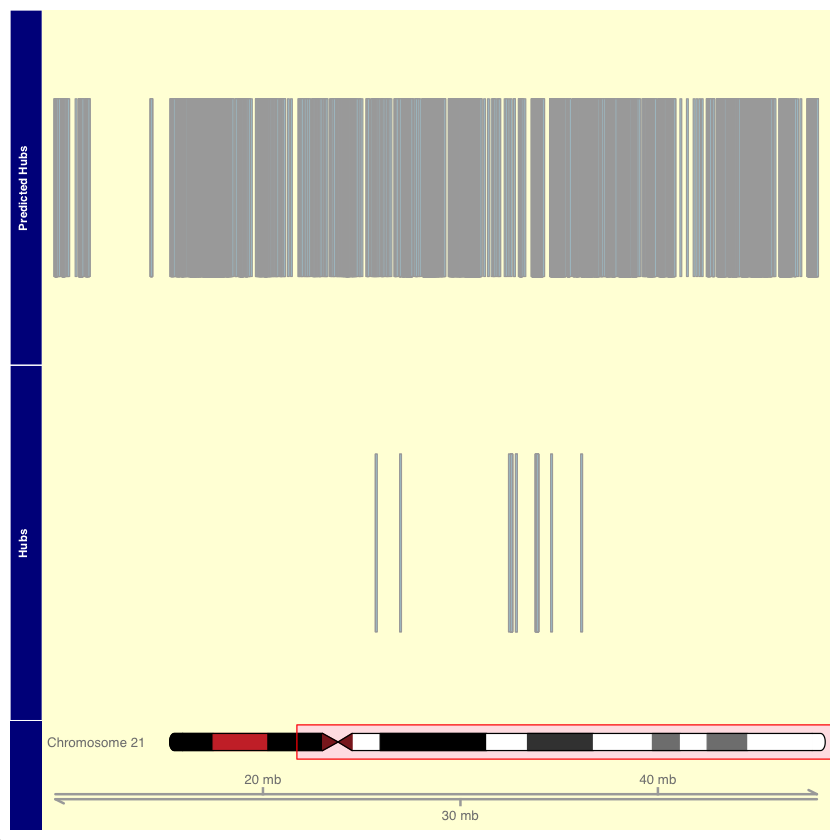

In [116]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = helagregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = helagregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

Exactly, what classes ...

In [117]:
helagregChr21PredicitedHub[helagregChr21PredicitedHub$Class == helagregChr21PredicitedHub$Prediction , ]

,chr,start,end,Class,Prediction
,<chr>,<int>,<int>,<chr>,<chr>
810642,chr21,26964001,26966000,Hub,Hub
810643,chr21,26966001,26968000,Hub,Hub
814077,chr21,33834001,33836000,Hub,Hub
814078,chr21,33836001,33838000,Hub,Hub
814079,chr21,33838001,33840000,Hub,Hub
814080,chr21,33840001,33842000,Hub,Hub
814081,chr21,33842001,33844000,Hub,Hub
814472,chr21,34612001,34614000,Hub,Hub
814473,chr21,34614001,34616000,Hub,Hub


### <a id=link13>7. Session Information </a>

In [118]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.32.0          GenomicRanges_1.40.0 GenomeInfoDb_1.24.2 
 [4] IRanges_2.22.2       S4Vectors_0.26.1     BiocGenerics_0.34.0 
 [7] DMwR_0.4.1           ROCR_1.0-11          ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         Hmisc_4.4-1          ggplot2_3.3.2       
[16] Formula_1.2-3        survival_3.2-3       lattice_0.20-41     
[19] glmnet_4.0-2         Matrix_1.2-18       

loaded via a namespace (and not attached):
  [1] uui